# Orr Sommerfeld pseudospectra

Let's use the classic Orr-Sommerfeld problem to explore *pseudospectra* with Dedalus. 

The Orr-Sommerfeld problem explores the stability of flow down a rectangular channel driven by a pressure gradient. The equilibrium solution is known analytically as plane Poiseuille flow, and is given by 

$$U(z) = 1 - z^2.$$

This shear flow becomes unstable despite having no inflection point in the flow. This is in contradiction to Rayleigh's inflection point theorem, which states that a *necessary* condition (for a *sufficient* condition, see [Balmforth and Morrison (1998)](https://arxiv.org/pdf/physics/9809024.pdf)). for a shear flow in an *inviscid* fluid to become unstable, it must have a point $z_i$ with

$$\frac{d^2 U}{dz^2}(z_i) = 0.$$

This means that for plane Poiseuille flow, the viscosity itself is the source of the instability.

If we write the problem in canonical Dedalus form

$$\mathcal{M}\frac{\partial \mathbf{X}}{\partial t} + \mathcal{L} \mathbf{X} = N(\mathbf{X}),$$

linearize about $U(z)$ (i.e. $N(\mathbf{X}) = 0$), and take the time dependence of $\mathbf{X} \propto e^{-ict}$, we have a generalized eigenvalue problem.

This is a very interesting problem because the linear operator for the Orr-Sommerfeld problem $\mathcal{L}_{OS}$ is non-normal, that is $\mathcal{L}_{OS}^\dagger \mathcal{L}_{OS} \neq \mathcal{L}_{OS}\mathcal{L}_{OS}^\dagger$. Non-normal operators can drive transient growth: even systems in which *all* eigenmodes are linearly stable and will decay to zero, arbitrary initial conditions can be amplified by large factors.

Here, we assume perturbations take the form $u(x,z,t) = \hat{u} e^{i\alpha (x - ct)}$, where $c = \omega/\alpha$ is the wave speed. One must take care to note that $c = c_r + i c_i$. If a perturbation has $c_i > 0$, it will linearly grow. This occurs at a Reynolds number $\mathrm{Re} \simeq 5772$, a result you can also find using `CriticalFinder` (it's actually a test problem for `eigentools`).

However, as we will see below, even at $\mathrm{Re} = 10000$, the growth rate is tiny: $c_i \approx 3.7\times10^{-3}$! Yet at those Reynolds numbers, channel flow is clearly unstable. How can this be?

The answer is that the *spectrum* of the Orr-Sommerfeld operator is quite misleading. Because $\mathcal{L}_{OS}$ is non-normal, its eigenfuntions are not orthogonal. As they decay at different rates, the total amplitude of some arbitrary initial condition can **increase**!

This observation was first noted in the pioneering paper by [Reddy, Schmid, and Henningson (1993)](https://www.jstor.org/stable/2102271?seq=1). For a detailed discussion of the Orr-Sommerfeld problem including a thorough discussion of transient growth, see [Schmid and Henningson (2001)](https://link.springer.com/book/10.1007/978-1-4613-0185-1).

In [1]:
import matplotlib.pyplot as plt
from mpi4py import MPI
from eigentools import Eigenproblem, CriticalFinder
import dedalus.public as de
import numpy as np
import time

## Orr-Sommerfeld problem 
First, we'll define the Orr-Sommerfeld equation in the usual way (following [Orszag 1971](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/accurate-solution-of-the-orrsommerfeld-stability-equation/39D4D85F9939CC4E2F4A7EF127DFB046)), in which the Navier-Stokes equations are reduced to a single fourth-order differential equation for the wall-normal velocity $w$. Because of the first order form of dedalus, this becomes four first order equations. 

Then we create an `Eigenproblem` object. 

In [2]:
z = de.Chebyshev('z', 128)
d = de.Domain([z],comm=MPI.COMM_SELF)

alpha = 1.
Re = 10000

orr_somerfeld = de.EVP(d,['w','wz','wzz','wzzz'],'c')
orr_somerfeld.parameters['alpha'] = alpha
orr_somerfeld.parameters['Re'] = Re
orr_somerfeld.substitutions['umean']= '1 - z**2'
orr_somerfeld.substitutions['umeanzz']= '-2'

orr_somerfeld.add_equation('dz(wzzz) - 2*alpha**2*wzz + alpha**4*w -1j*alpha*Re*((umean-c)*(wzz - alpha**2*w) - umeanzz*w) = 0')
orr_somerfeld.add_equation('dz(w)-wz = 0')
orr_somerfeld.add_equation('dz(wz)-wzz = 0')
orr_somerfeld.add_equation('dz(wzz)-wzzz = 0')

orr_somerfeld.add_bc('left(w) = 0')
orr_somerfeld.add_bc('right(w) = 0')
orr_somerfeld.add_bc('left(wz) = 0')
orr_somerfeld.add_bc('right(wz) = 0')

# create an Eigenproblem object
EP = Eigenproblem(orr_somerfeld)

2020-12-23 09:00:14,915 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2020-12-23 09:00:14,942 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


Calling the `solve` method on the `Eigenproblem` object will solve the eigenvalue problem with 128 modes and then solve it again with $3/2 \cdot 128 = 192$ modes. Using the rejection algorithm detailed in Chapter 7 of [Boyd (1989)](https://store.doverpublications.com/0486411834.html), `eigentools` creates `EP.evalues` which holds only the good eigenvalues: those that are the same (to some specified tolerance) between both solves. 

Of course, `EP.evalues_low` and `EP.evalues_high` store the low and high resolution eigenvalues, respectively, if you need them. 

The `sparse=False` option tells Dedalus to use the dense eigenvalue solver, which will retrieve all the eigenmodes (as many as there are modes in the problem). Of course, about half of them will be unusably inaccurate; the rejection methods in `eigentools` hides those from us.

In [3]:
EP.solve(sparse=False)

We mark the stability threshold with a light grey line. We can find the growth rate also:

In [4]:
print(r"fastest growth rate: max(c_i) = {:5.3e}".format(np.max(EP.evalues.imag)))

fastest growth rate: max(c_i) = 3.740e-03


Text(0, 0.5, '$c_i$')

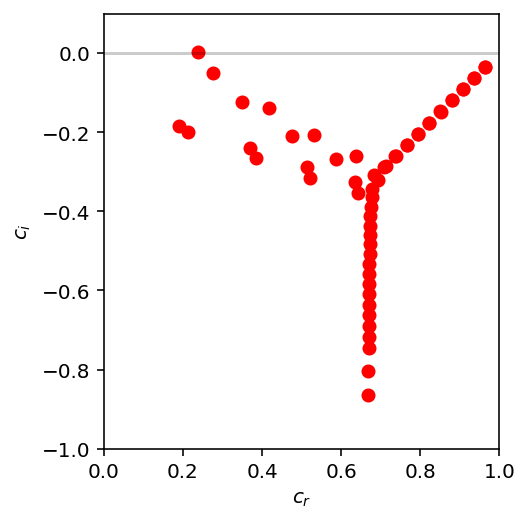

In [5]:
plt.scatter(EP.evalues.real, EP.evalues.imag,color='red')
plt.axis('square')
plt.axhline(0,color='k',alpha=0.2)
plt.xlim(0,1)
plt.ylim(-1,0.1)
plt.xlabel(r"$c_r$")
plt.ylabel(r"$c_i$")

## Pseudospectra

The `Eigenproblem` object also provides a simple method to calculate pseudospectra, `calc_ps()`. Pseudospectra were originally defined for regular eigenvalue problems. In order to calculate pseudospectra for the differential-algebraic equation systems Dedalus typically provides, we use the algorithm developed by [Embree and Keeler (2017)](https://intranet.math.vt.edu/people/embree/M105501.pdf). This uses the sparse eigenvalue solver to construct an invariant subspace to approximate a regular eigenvalue problem. Typically, it requires a rather high number of modes, $k$. Here we set $k = 100$. After we construct the approximate matrix, we feed it to a standard pseudospectrum routine. This requres a set of points in the complex plane at which the pseudospectrum will be computed. We do that by choosing a set of real and imaginary points, and feeding them to the `EP.calc_ps()` method. 

In [6]:
k = 100

psize = 100
real_points = np.linspace(0,1, psize)
imag_points = np.linspace(-1,0.1, psize)

The concept of non-normality is inherently linked to the norm used to evaluate orthogonality. When calculating pseudospectra, one must specify the norm to be used. 

`eigentools` allows users to pass a norm function to the pseudospectrum calculation. If you do not pass a norm, it will simply use the standard vector 2-norm in the coffiecient space. **This is almost assuredly unphysical**. However, it is simple to write a function to use the energy norm (or anything else). 

Here, we will use the energy inner product for the Orr-Sommerfeld form of the equations,

$$<\mathbf{X}_1|\mathbf{X}_2>_E = \int_{-1}^{1} w_1^\dagger w_2 + \frac{(\partial_z w_1)^\dagger \partial_z w_2}{\alpha^2} dz$$,

with $\mathbf{X}_{1,2}$ state vectors containing $w$ and its first three derivatives. This inner product induces a norm $||\mathbf{X}||_E$ that is equal to the energy of the perturbation.

The input to the functions will be Dedalus `FieldSystem` objects which will be populated by `EP.calc_ps()`. 
Note that the function returns the energy itself, that is it calls `field['g'][0]` to return the integral in grid space.

In [7]:
def energy_norm(X1, X2):
    u1 = X1['wz']/alpha
    w1 = X1['w']
    u2 = X2['wz']/alpha
    w2 = X2['w']
    
    field = (np.conj(u1)*u2 + np.conj(w1)*w2).evaluate().integrate()
    return field['g'][0]

Now we can call `calc_ps` with the points we defined above and `energy_norm`:

In [8]:
EP.calc_ps(k, (real_points, imag_points), inner_product=energy_norm)

This adds data attributes `EP.pseudospectrum`, `EP.ps_real`, `EP.ps_imag` to the `EP` object, storing the pseudospectrum contours, and the real and imaginary grid for conveninece. 

Traditionally, one plots pseudospectra as logarithmic contours over top of the spectrum. Here, the contours are from -1 to -8 from outside in. This means that a perturbation of amplitude $\epsilon \simeq 10^{-1}$ to $\epsilon \simeq 10^{-8}$ will cause an $\mathcal{O}(1)$ change in the eigenvalues within that contour. Importantly, transient growth is possible within all of the contours that cross $c_i > 0$ with amplification factors proportional to $1/\epsilon$. Here, we can clearly see why channel flow is turbulent even when the only unstable mode has such a feeble growth rate!

Text(0, 0.5, '$c_i$')

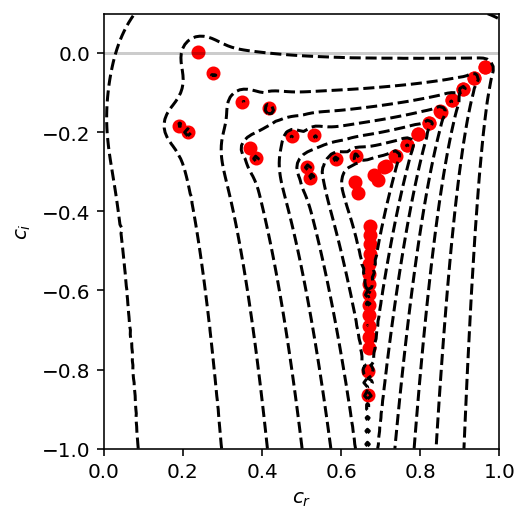

In [9]:
plt.scatter(EP.evalues.real, EP.evalues.imag,color='red')
plt.contour(EP.ps_real,EP.ps_imag, np.log10(EP.pseudospectrum),levels=np.arange(-8,0),colors='k')
plt.axis('square')
plt.axhline(0,color='k',alpha=0.2)

plt.xlim(0,1)
plt.ylim(-1,0.1)
plt.xlabel(r"$c_r$")
plt.ylabel(r"$c_i$")

## Primitive Form

One of the great advantages of Dedalus is that we can study problems without having to manipulate them into special forms, as in the case of the Orr-Sommerfeld operator. After all, this is nothing more than a special form of the 2-D Navier-Stokes equation linearized around $U(z)$.

We should be able to enter the "primitive" form of the equations and get equivalent results. Here, we define a new Dedalus `EVP`, and then feed it to `eigentools`.

In [10]:
primitive = de.EVP(d,['u','w','uz','wz', 'p'],'c')
primitive.parameters['alpha'] = alpha
primitive.parameters['Re'] = Re

primitive.substitutions['umean'] = '1 - z**2'
primitive.substitutions['umeanz'] = '-2*z'
primitive.substitutions['dx(A)'] = '1j*alpha*A' 
primitive.substitutions['dt(A)'] = '-1j*alpha*c*A'
primitive.substitutions['Lap(A,Az)'] = 'dx(dx(A)) + dz(Az)'

primitive.add_equation('dt(u) + umean*dx(u) + w*umeanz + dx(p) - Lap(u, uz)/Re = 0')
primitive.add_equation('dt(w) + umean*dx(w) + dz(p) - Lap(w, wz)/Re = 0')
primitive.add_equation('dx(u) + wz = 0')
primitive.add_equation('uz - dz(u) = 0')
primitive.add_equation('wz - dz(w) = 0')
primitive.add_bc('left(w) = 0')
primitive.add_bc('right(w) = 0')
primitive.add_bc('left(u) = 0')
primitive.add_bc('right(u) = 0')


prim_EP = Eigenproblem(primitive)

2020-12-23 09:00:34,186 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2020-12-23 09:00:34,207 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


Again, we solve the dense eigenproblem just to get the full spectrum.

In [11]:
prim_EP.solve(sparse=False)

And we recalculate the pseudospectrum, covering the same part of the complex plane.

However, the energy norm in primitive variables is slightly different:

$$<\mathbf{X}_1|\mathbf{X}_2>_E = \int_{-1}^{1} u_1^\dagger u_2 + w_1^\dagger w_2 dz$$,

so we write another `energy_norm` function and then call `prim_EP.calc_ps` with the same arguments as before.

In [12]:
def energy_norm(Q1, Q2):
    u1 = Q1['u']
    w1 = Q1['w']
    u2 = Q2['u']
    w2 = Q2['w']
    
    field = (np.conj(u1)*u2 + np.conj(w1)*w2).evaluate().integrate()
    return field['g'][0]

In [13]:
prim_EP.calc_ps(k, (real_points, imag_points), inner_product=energy_norm)


Now, let's plot both the Orr-Sommerfeld form and the primitive form.

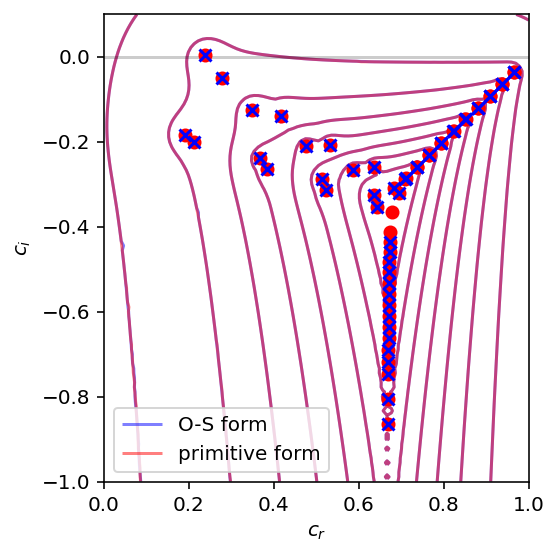

In [14]:
clevels = np.arange(-8,0)
OS_CS = plt.contour(EP.ps_real,EP.ps_imag, np.log10(EP.pseudospectrum),levels=clevels,colors='blue',linestyles='solid', alpha=0.5)
P_CS = plt.contour(prim_EP.ps_real,prim_EP.ps_imag, np.log10(prim_EP.pseudospectrum),levels=clevels,colors='red',linestyles='solid', alpha=0.5)

plt.scatter(prim_EP.evalues.real, prim_EP.evalues.imag,color='red',zorder=3)
plt.scatter(EP.evalues.real, EP.evalues.imag,color='blue',marker='x',zorder=4)

lines = [OS_CS.collections[0],P_CS.collections[0]]
labels = ['O-S form', 'primitive form']

plt.axis('square')
plt.xlim(0,1)
plt.ylim(-1,0.1)
plt.axhline(0,color='k',alpha=0.2)
plt.xlabel(r"$c_r$")
plt.ylabel(r"$c_i$")
plt.legend(lines, labels)
plt.tight_layout()
plt.savefig("OS_pseudospectra.png", dpi=300)

We see that the on the whole, there is very good agreement. The primitive form has more good eigenvalues (red dots with no corresponding blue crosses; none of the converse). Furthermore, the pseudospectra contours are indistinguishable except in the lower branch around $(c_r, c_i) = (0.65,-0.8)$.